In [1]:
import velvetvae as vt

# general packages
import numpy as np
import pandas as pd
import torch
from scipy.sparse import issparse

# velocity packages
import scanpy as sc
import scvelo as scv
import anndata as ann

# plotting packages
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from IPython.display import clear_output

# color palette object
from colors import colorpalette as colpal

Global seed set to 0
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/camp/home/maizelr/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
import torchsde
import time

In [3]:
nmp = sc.read_h5ad('../data/nmp_data_1606.h5ad')
nmp

AnnData object with n_obs × n_vars = 24262 × 1229
    obs: 'X_TC_alpha', 'total_TC_alpha', 'unspliced_TC_alpha', 'spliced_TC_alpha', 'p_e', 'p_c_TC', 'sample', 'timepoint', 'rep', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label_rate', 'doublet_score', 'marker_based_classification', 'cell_annotation', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors'
    obsm: 'Ts', 'X_z', 'knn_index', 'velocity_z'
    layers: 'new', 'old', 'total'
    obsp: 'connectivities', 'distances'

In [4]:
state_path = '../models/nmp_vf_1606_model.pt'

vt.md.Velvet.setup_anndata(nmp, x_layer='total', n_layer='new', knn_layer='knn_index')

model = vt.md.Velvet(
    nmp,
    n_latent = 50,
    linear_decoder = True,
    neighborhood_space="latent_space",
    biophysical_model = "full",
    gamma_mode = "learned",
    labelling_time = 2.0,
)

model.setup_model()

trained_state = torch.load(state_path)['model_state_dict']

model.module.load_state_dict(trained_state)
model.module = model.module.to('cuda')

INFO     Generating sequential column names                                                  


In [5]:
model.module = model.module.to('cuda')

mp = vt.sb.MarkovProcess(
    model,
    n_neighbors=10,
    use_space='latent_space',
    use_spline=True,
    use_similarity=False
)

sde = vt.sb.SDE(
    model.module.n_latent,
    prior_vectorfield=model.module.vf,
    noise_scalar=0.2,
    device=model.device
)

model.adata.obs['index'] = np.arange(model.adata.shape[0])

vt.sm.VelvetSDE.setup_anndata(
    model, 
    x_layer='total', 
    index_key='index'
)

sde_model = vt.sm.VelvetSDE(
    model,
    sde,
    mp,
)

sde_model.module = sde_model.module.to('cuda')

KNN indices for Velvet stored in .obsm['knn_index'].


In [12]:
np.linspace(100,1000,10)

np.linspace(20,200,4)

array([ 20.,  80., 140., 200.])

# time

In [19]:
X = []
Y = []
for j in tqdm(np.linspace(20,200,4)):   
    x, y = [], []
    for i in np.linspace(100,1000,10):
        try:
            start = time.time()
            sde_model.train(
                max_epochs = 10,
                n_trajectories = int(i),
                n_simulations = int(j),
                n_steps = 30,
                n_markov_steps=15,
                t_max=25,
                dt = 1.0,
                lr = 0.001,
            )
            end = time.time()
            d = (end - start)/10
            x.append(d)
            y.append(i)
        except RuntimeError as e: 
            if "out of memory" in str(e):
                print("Caught an OutOfMemoryError!")
            else:
                raise
    X.append(x)
    Y.append(y)

  0%|          | 0/4 [00:00<?, ?it/s]bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s, loss=230, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:02<00:00,  3.50it/s, loss=230, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s, loss=376, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s, loss=376, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  2.84it/s, loss=452, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  2.81it/s, loss=452, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s, loss=387, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, loss=387, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s, loss=321, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s, loss=321, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s, loss=467, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.13it/s, loss=467, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s, loss=417, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s, loss=417, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s, loss=281, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s, loss=281, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s, loss=579, v_num=1]   

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s, loss=579, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s, loss=331, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s, loss=331, v_num=1]

 25%|██▌       | 1/4 [00:50<02:32, 50.89s/it]

bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, loss=72.1, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s, loss=72.1, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s, loss=58.4, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s, loss=58.4, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s, loss=58.3, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s, loss=58.3, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s, loss=60.8, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s, loss=60.8, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it, loss=59.1, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it, loss=59.1, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it, loss=67.3, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:12<00:00,  1.28s/it, loss=67.3, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:15<00:00,  1.48s/it, loss=64, v_num=1]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:15<00:00,  1.51s/it, loss=64, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it, loss=63.2, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it, loss=63.2, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it, loss=55.6, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it, loss=55.6, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it, loss=51.3, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it, loss=51.3, v_num=1]

 50%|█████     | 2/4 [02:55<03:09, 94.51s/it]

bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s, loss=41.2, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s, loss=41.2, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s, loss=43.9, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s, loss=43.9, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it, loss=39.6, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:11<00:00,  1.15s/it, loss=39.6, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=42.2, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it, loss=42.2, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it, loss=37, v_num=1]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it, loss=37, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it, loss=34.2, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:21<00:00,  2.11s/it, loss=34.2, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/10:  20%|██        | 2/10 [00:05<00:20,  2.61s/it, loss=43.7, v_num=1]Caught an OutOfMemoryError!


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]


bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]Caught an OutOfMemoryError!


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [04:27<01:33, 93.05s/it]

Caught an OutOfMemoryError!


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s, loss=34.9, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s, loss=34.9, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:10<00:00,  1.09s/it, loss=30.6, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:10<00:00,  1.10s/it, loss=30.6, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it, loss=30.2, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it, loss=30.2, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 10/10: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it, loss=28.8, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it, loss=28.8, v_num=1]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]Caught an OutOfMemoryError!


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]Caught an OutOfMemoryError!


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]Caught an OutOfMemoryError!


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]Caught an OutOfMemoryError!


bypassing sigterm
bypassing sigterm
bypassing sigterm
Multiprocessing is handled by SLURM.
bypassing sigterm
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
bypassing sigterm
bypassing sigterm
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 1/10:   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 4/4 [05:27<00:00, 81.89s/it]

Caught an OutOfMemoryError!


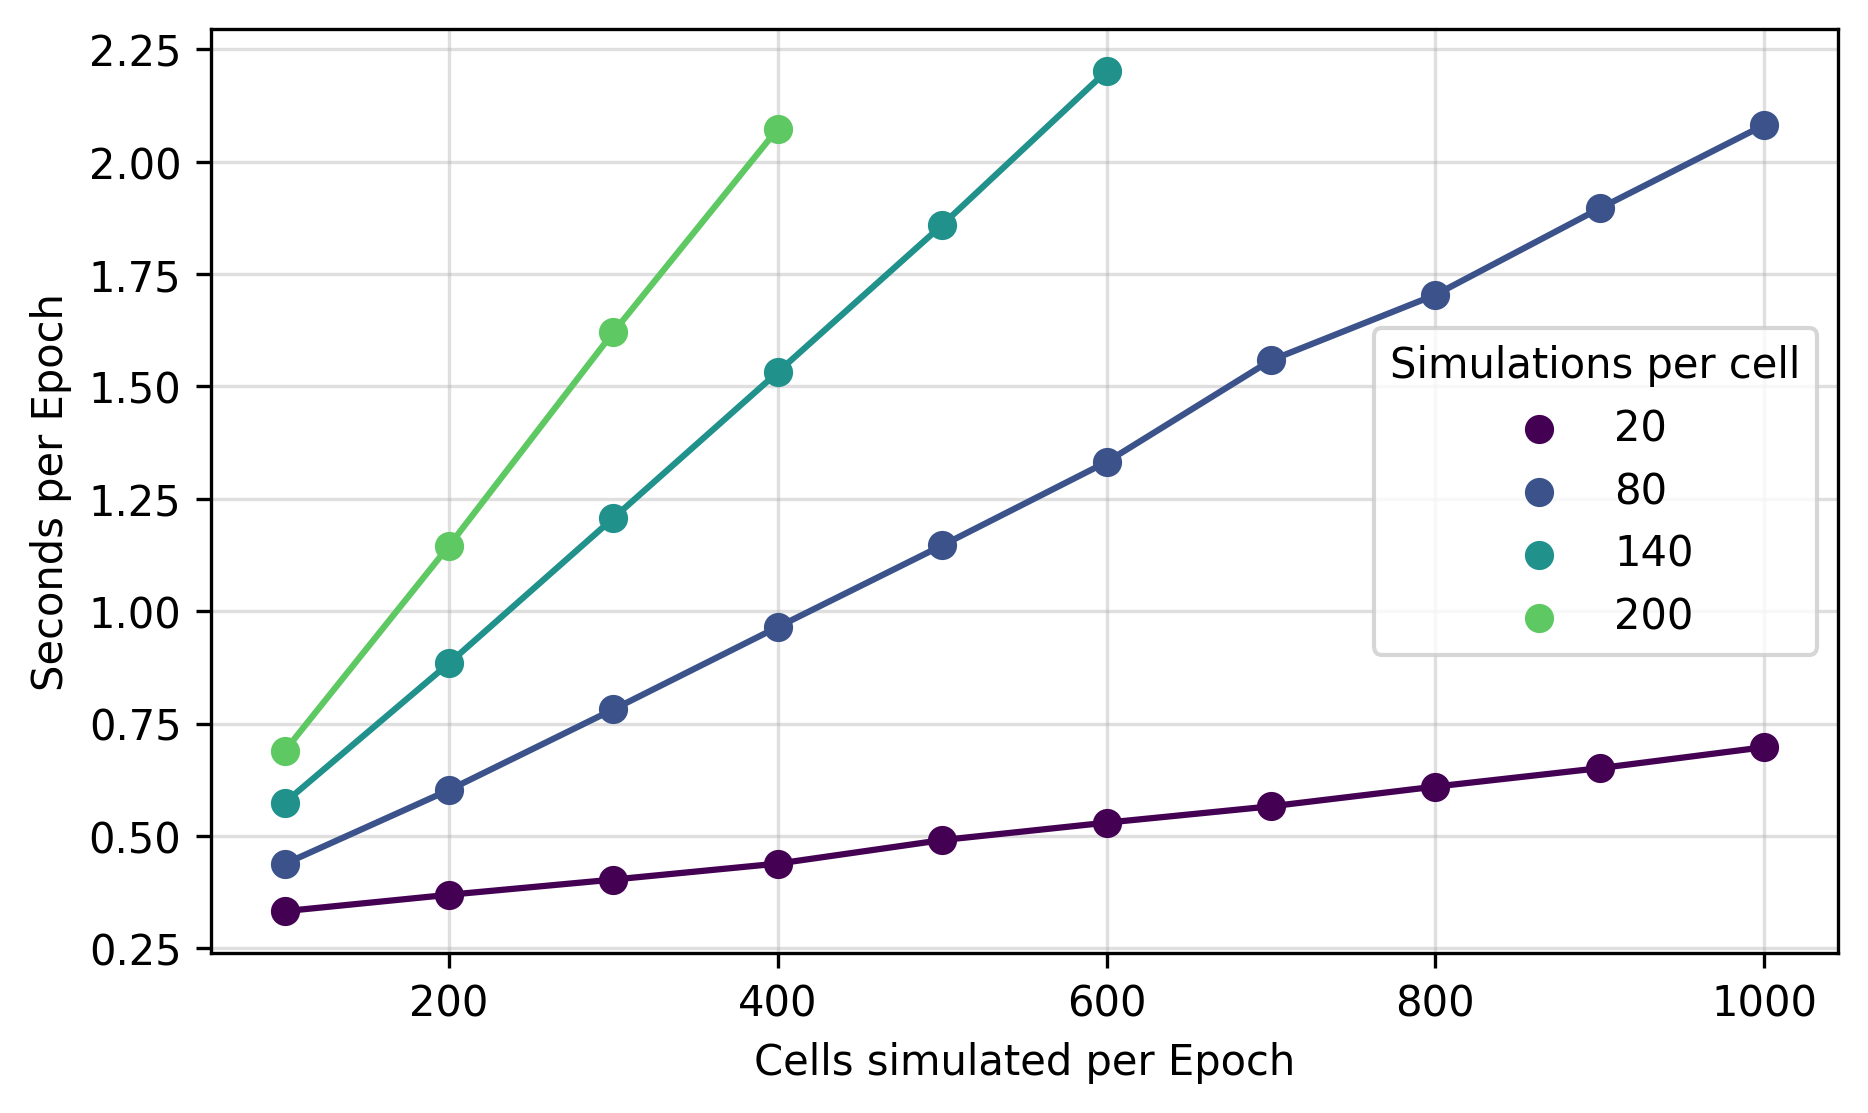

In [43]:
def gcsc(n):
    import matplotlib
    cmap = plt.cm.viridis
    return [matplotlib.colors.rgb2hex(cmap(i / n)) for i in range(n)]

C = gcsc(4)

L = np.linspace(20,200,4).astype(int)
plt.figure(figsize=(7,4), dpi=300)
for x,y,l,c in zip(X,Y,L,C):
    plt.plot(y,x, zorder=54, color=c)
    plt.scatter(y,x, zorder=56, label=l, color=c)
    plt.grid(alpha=0.4, zorder=50)
    plt.ylabel("Seconds per Epoch")
    plt.xlabel("Cells simulated per Epoch")
plt.legend(title='Simulations per cell')
plt.savefig('../figures/2.5.2_SDE_training_time.png', transparent=True)
plt.show()